# LightGBM 예측

차례: </br>
1. 데이터셋 전처리
* 타겟 데이터 범주형 범주 설정
* 타겟 데이터 범주형 변환 (https://dataplay.tistory.com/2)
2. 범주형 변수 학습&예측


LightGBM은 카테고리형 변수도 그대로 학습이 가능합니다. 원핫인코딩보다 성능이 좋은 경우가 많다고 하니 두 가지 경우 모두 확인해보도록 하겠습니다.
(https://herjh0405.tistory.com/40)


## 1. 데이터셋 변환

### 데이터셋 불러오기

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [34]:
raw_df = pd.read_csv('data/CS.csv')

In [35]:
# 시도, 성별 drop하기

df = raw_df.drop(['sido', 'age'], axis=1)

In [36]:
df

,view_cnt,where_cnt,attend_cnt,volunteer_cnt,history_cnt,festival_cnt,standard,block,expense,expense_f,...,history,history_f,festival,festival_f,sex,education,married,work,income,disabled
0,49,0,0,0,5,0,1,1,14,14,...,1,6,2,6,2,3,1,5,3,1
1,3,5,1,0,1,0,2,6,14,9,...,1,7,2,7,2,3,2,5,7,1
2,6,0,0,0,0,0,2,1,8,15,...,2,4,2,4,1,3,1,5,6,1
3,22,12,2,0,0,0,1,2,14,14,...,2,4,2,5,2,4,2,5,5,1
4,16,3,2,0,2,0,2,1,14,14,...,1,5,2,4,2,4,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20619,59,7,0,0,5,1,4,3,14,14,...,1,6,1,6,2,4,2,1,6,1
20620,49,6,0,0,2,1,1,2,14,14,...,1,6,1,6,2,4,2,5,4,1
20621,4,0,0,0,0,0,1,2,17,14,...,2,4,2,4,1,4,2,2,6,1
20622,58,5,0,0,0,2,1,2,14,14,...,2,6,1,6,2,4,2,5,5,1


### 타겟/ 데이터 분리

In [37]:
# drop by Name
df_data = df.drop(['view_cnt'], axis=1)

# Select the ones you want
df_target = df[['view_cnt']]

## 1B 타겟 (View_cnt) 범주형 데이터 처리

### 방법1 카테고리 데이터로 변환

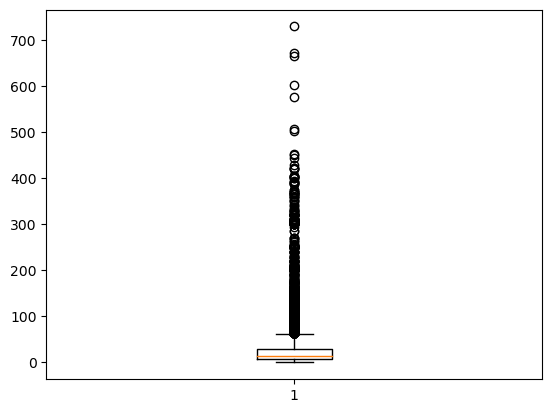

In [38]:
bp = plt.boxplot(df_target)

In [39]:
# 박스플롯은 딕셔너리 형태이기 때문에 아래와 같이 키를 가져올 수 있습니다:
# bp.keys()
q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]
print(f'Q1: {q1}\n'
      f'Q3: {q3}')
print('median: ',df_target['view_cnt'].median())
print('mean: ',round(df_target['view_cnt'].mean()))


Q1: [7.0]
Q3: [29.0]
median:  15.0
mean:  25


세 그룹으로 나누기

1. 적게 관람한 그룹
* 0회 ~ Q1(7회)  => 0
2. 평균적으로 관람한 그룹
* Q1(7회) ~ mean(25회) => 1 
3. 많이 관람한 그룹
* mean(25회) ~  => 2

In [40]:
df_target.isna().sum()
# 0로 채워진 view_cat category 생성
# df_target['view_cat'] = 0

view_cnt    0
dtype: int64

In [41]:
# 7보다 크거나 같고 25보다 작을시 view_cat 값을 1로 설정
df_target.loc[(7 > df_target['view_cnt']), 'view_cat'] = 0
df_target.loc[(7 <= df_target['view_cnt']) & (df_target['view_cnt'] <25), 'view_cat'] = 1
# 25보다 클시 view_cat 값을 2로 설정
df_target.loc[25 <= df_target['view_cnt'], 'view_cat'] = 2
df_target
# df_target['view_cnt'][2]

# view_cnt 열 삭제
df_target = df_target.drop(['view_cnt'], axis='columns')

/var/folders/4w/6qs7j4ts30gbpm461svyy5vc0000gn/T/ipykernel_46127/628382003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target.loc[(7 > df_target['view_cnt']), 'view_cat'] = 0


In [42]:
df_target.isna().sum()

view_cat    0
dtype: int64

## 2 범주형 변수 학습&예측

### Test Train split

In [11]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(df_data, 
                                                  df_target, 
                                                  test_size=0.2, 
                                                  random_state=156 )

In [12]:
# NA 없이 모두 잘 처리되었음을 확인
y_train.isna().sum()

view_cat    0
dtype: int64

### 모델 학습

In [13]:
from lightgbm import LGBMClassifier

# 분류기 수 : 400
lgbm_clf = LGBMClassifier(n_estimators=400)

eval_data = [(X_test, y_test)]

In [14]:
# 범주형 변수 지정
cat_features = ['sex', 'age', 'education', 'married', 'work', 'income', 'sido', 'disabled', 'dv_cnt', 'standard', 'block', 'mv_cnt', 'expense', 'expense_f', 'difficulty', 'intention', 'history', 'history_f', 'festival', 'festival_f']


In [21]:
from lightgbm import early_stopping
from sklearn.metrics import confusion_matrix, accuracy_score

lgbm_clf.fit(X_train, y_train, 
            callbacks=[early_stopping(100)],
            eval_metric='logloss', 
            eval_set=eval_data,
            verbose=True)
            # categorical_feature = cat_features)       
        
# Early stopping, best iteration is:
# [160]	valid_0's multi_logloss: 0.925621

#  # 이후 더 이상 향상된 값을 찾을 수 없음

/Users/yeonjinkim/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yeonjinkim/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/yeonjinkim/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/yeonjinkim/anaconda3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 've

[1]	valid_0's multi_logloss: 1.04039
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.02835
[3]	valid_0's multi_logloss: 1.0186
[4]	valid_0's multi_logloss: 1.01004
[5]	valid_0's multi_logloss: 1.00345
[6]	valid_0's multi_logloss: 0.997535
[7]	valid_0's multi_logloss: 0.992677
[8]	valid_0's multi_logloss: 0.988597
[9]	valid_0's multi_logloss: 0.984319
[10]	valid_0's multi_logloss: 0.981126
[11]	valid_0's multi_logloss: 0.978174
[12]	valid_0's multi_logloss: 0.975256
[13]	valid_0's multi_logloss: 0.972913
[14]	valid_0's multi_logloss: 0.970732
[15]	valid_0's multi_logloss: 0.96857
[16]	valid_0's multi_logloss: 0.966949
[17]	valid_0's multi_logloss: 0.965499
[18]	valid_0's multi_logloss: 0.964149
[19]	valid_0's multi_logloss: 0.963372
[20]	valid_0's multi_logloss: 0.962819
[21]	valid_0's multi_logloss: 0.962219
[22]	valid_0's multi_logloss: 0.961189
[23]	valid_0's multi_logloss: 0.96016
[24]	valid_0's multi_logloss: 0.959701
[25]	valid_0's mult

[212]	valid_0's multi_logloss: 0.954162
[213]	valid_0's multi_logloss: 0.953932
[214]	valid_0's multi_logloss: 0.95398
[215]	valid_0's multi_logloss: 0.953902
[216]	valid_0's multi_logloss: 0.954027
Early stopping, best iteration is:
[116]	valid_0's multi_logloss: 0.948478


LGBMClassifier(n_estimators=400)

In [22]:
y_pred = lgbm_clf.predict(X_test)
accuracy = accuracy_score(y_test , y_pred)

print('LightGBM 예측 정확도 : {0:.4f}'.format(accuracy))

LightGBM 예측 정확도 : 0.5285


### 모델 예측

In [16]:
# 예측
y_pred = lgbm_clf.predict(X_test)
pred_proba = lgbm_clf.predict_proba(X_test)

In [17]:
print(y_pred)
print(pred_proba)

[1. 1. 1. ... 2. 1. 0.]
[[0.22774952 0.6613771  0.11087338]
 [0.11982044 0.64897572 0.23120383]
 [0.38842624 0.41404814 0.19752562]
 ...
 [0.09957597 0.4259079  0.47451613]
 [0.23639205 0.52141383 0.24219411]
 [0.48546196 0.36393773 0.15060032]]


In [18]:
roc_auc_score(y_test, pred_proba, multi_class='ovr')

NameError: name 'roc_auc_score' is not defined

### 평가

In [ ]:
# 평가 지표 함수 : 앞에서 작성한 것 복사했음

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, y_pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test , y_pred)
    precision = precision_score(y_test , y_pred, average='micro')
    recall = recall_score(y_test , y_pred, average='micro')
    f1 = f1_score(y_test,y_pred, average='micro')
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovr')
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도:{1:4f}, 재현율: {2:.4f}, F1: {2:.4f}, AUC:{4:.4f}'.format(accuracy, 
                                                                                    f1, recall, precision, roc_auc))
    

In [ ]:
get_clf_eval(y_test, y_pred, pred_proba)

# 결과 
# 정확도 : 0.5285
# binary하지 않은 데이터셋에서는
# average='micro'를 사용해야 함
# 이 경우에는 accuracy == recall == precision == f1-score가 된다고 함
# 출처:
# https://stackoverflow.com/questions/52269187/facing-valueerror-target-is-multiclass-but-average-binary

In [25]:
import seaborn as sns

<Axes: >

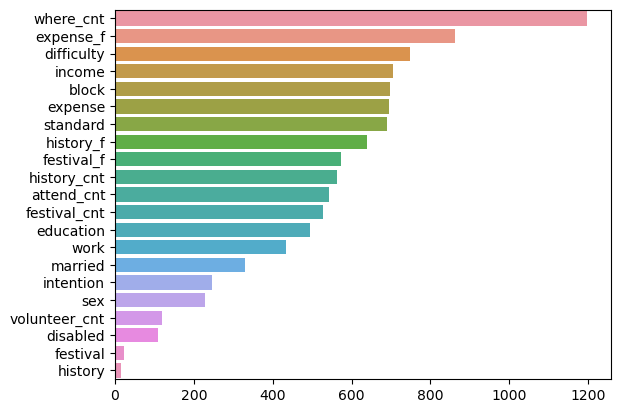

In [27]:
feat_imp = pd.Series(lgbm_clf.feature_importances_, index=df_data.columns).sort_values(ascending=False)
# feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

sns.barplot(x=feat_imp,y=feat_imp.index)

## 하이퍼파라미터 튜닝

GridSearchCV 사용

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# 하이퍼 파라미터 설정


parameters = {
    # 중요 파라미터
    'num_leaves':[30, 45, 60 ],
    # 중요 파라미터
    'max_depth' :[ 5, 10],
    # 중요 파라미터
    'min_data_in_leaf':[15,25, 35, 45 ],
    'max_iter': [100]

    
#     'feature_fraction': [ 0.6, 0.8,  0.9],
#     'bagging_fraction': [  0.6, 0.8 ],
#     'bagging_freq': [   100, 200, 400  ],
#     'task' : ['predict'],
#     'boosting': ['gbdt' ],
#     'objective': ['multiclass'],
#     'num_iterations': [  1500, 2000,5000  ],
#     'learning_rate':[  0.05, 0.005 ],
}


In [ ]:
from numpy import ravel

In [ ]:
y_train = ravel(y_train)

### CV = 5일 때

In [ ]:
# CV = 5

# GridSearchCV 이용해서 최적의 하이퍼 파라미터 찾음

grid_lgbm = GridSearchCV(lgbm_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_lgbm.fit(X_train, y_train)


# 최적 하이퍼 파라미터로 학습된 Estimator로 예측/평가 수행

print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_lgbm.best_params_)
print('GridSearchCV 최고 정확도 : {0:.4f}'.format(grid_lgbm.best_score_))

best_lgbm = grid_lgbm.best_estimator_


# 최적 하이퍼 파라미터로 학습된 Estimator로 예측/평가 수행
y_pred = best_lgbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('하이퍼 파라미터 튜닝을 끝낸 최종 정확도 : {0:.4f}'.format(accuracy))

In [ ]:
# parameters = {
#     # 중요 파라미터
#     'num_leaves':[ 7, 15, 31  ],
#     # 중요 파라미터
#     'max_depth' :[ 10,15,25],
#     # 중요 파라미터
#     'min_data_in_leaf':[15,25 ],
#     'max_iter': [100]
#}

# GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 10, 'max_iter': 100, 'min_data_in_leaf': 25, 'num_leaves': 15}
# GridSearchCV 최고 정확도 : 0.5319
# 하이퍼 파라미터 튜닝을 끝낸 최종 정확도 : 0.5328


In [ ]:
# parameters = {
#     # 중요 파라미터
#     'num_leaves':[ 5, 15, 30, 45  ],
#     # 중요 파라미터
#     'max_depth' :[ 5, 10,15,25],
#     # 중요 파라미터
#     'min_data_in_leaf':[15,25, 35, 45 ],
#     'max_iter': [100]
# }

# GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 5, 'max_iter': 100, 'min_data_in_leaf': 35, 'num_leaves': 45}
# GridSearchCV 최고 정확도 : 0.5323
# 하이퍼 파라미터 튜닝을 끝낸 최종 정확도 : 0.5297

In [ ]:
# parameters = {
#     # 중요 파라미터
#     'num_leaves':[30, 45, 60 ],
#     # 중요 파라미터
#     'max_depth' :[ 5, 10],
#     # 중요 파라미터
#     'min_data_in_leaf':[15,25, 35, 45 ],
#     'max_iter': [100]


GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 5, 'max_iter': 100, 'min_data_in_leaf': 35, 'num_leaves': 45}
GridSearchCV 최고 정확도 : 0.5323
하이퍼 파라미터 튜닝을 끝낸 최종 정확도 : 0.5297

In [ ]:
# parameters = {
#     # 중요 파라미터
#     'num_leaves':[30, 45],
#     # 중요 파라미터
#     'max_depth' :[2,3,4, 5],
#     # 중요 파라미터
#     'min_data_in_leaf':[35, 45],
#     'max_iter': [500]

# GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 2, 'max_iter': 500, 'min_data_in_leaf': 45, 'num_leaves': 30}
# GridSearchCV 최고 정확도 : 0.5303
# 하이퍼 파라미터 튜닝을 끝낸 최종 정확도 : 0.5295

### 최종 모델 feature importance

In [139]:
# parameters 적는 방법
{'max_depth': 5, 'max_iter': 100, 'min_data_in_leaf': 35, 'num_leaves': 45}

lgbm_clf.fit(X_train, y_train, 
            callbacks=[early_stopping(100)],
            eval_metric='logloss', 
            eval_set=eval_data,
            verbose=True,
            max_depth = 5,
            min_data_in_leaf = 35,
            num_leaves = 45,
            max_iter = 100)

TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'max_depth'

### CV = 3일 때

In [ ]:
# CV = 3

# GridSearchCV 이용해서 최적의 하이퍼 파라미터 찾음

grid_lgbm = GridSearchCV(lgbm_clf, param_grid=parameters, scoring='accuracy', cv=3)
grid_lgbm.fit(X_train, y_train)


# 최적 하이퍼 파라미터로 학습된 Estimator로 예측/평가 수행

print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_lgbm.best_params_)
print('GridSearchCV 최고 정확도 : {0:.4f}'.format(grid_lgbm.best_score_))

best_lgbm = grid_lgbm.best_estimator_


# 최적 하이퍼 파라미터로 학습된 Estimator로 예측/평가 수행
y_pred = best_lgbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('하이퍼 파라미터 튜닝을 끝낸 최종 정확도 : {0:.4f}'.format(accuracy))

In [ ]:
# parameters = {
#     # 중요 파라미터
#     'num_leaves':[ 7, 15, 31  ],
#     # 중요 파라미터
#     'max_depth' :[ 10,15,25],
#     # 중요 파라미터
#     'min_data_in_leaf':[15,25 ],
#     'max_iter': [100]
    
# GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 10, 'max_iter': 100, 'min_data_in_leaf': 25, 'num_leaves': 31}
# GridSearchCV 최고 정확도 : 0.5299
# 하이퍼 파라미터 튜닝을 끝낸 최종 정확도 : 0.5304


### + 발표 자료 만들기 : view_cat 값에 따라 관람 걸림돌 시각화

In [103]:
from matplotlib import rc
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [43]:
# 데이터셋: df_target, df_

# view_cat = 0  =>  하위 관람 그룹
# view_cat = 1  =>  평균 관람 그룹
# view_cat = 2  =>  상위 관람 그룹

NameError: name 'view_cat' is not defined

In [49]:
# df_data, df_target merge
view_data = pd.concat([df_data,df_target],axis=1)

In [50]:
view_data

,where_cnt,attend_cnt,volunteer_cnt,history_cnt,festival_cnt,standard,block,expense,expense_f,difficulty,...,history_f,festival,festival_f,sex,education,married,work,income,disabled,view_cat
0,0,0,0,5,0,1,1,14,14,3,...,6,2,6,2,3,1,5,3,1,2.0
1,5,1,0,1,0,2,6,14,9,1,...,7,2,7,2,3,2,5,7,1,0.0
2,0,0,0,0,0,2,1,8,15,1,...,4,2,4,1,3,1,5,6,1,0.0
3,12,2,0,0,0,1,2,14,14,4,...,4,2,5,2,4,2,5,5,1,1.0
4,3,2,0,2,0,2,1,14,14,4,...,5,2,4,2,4,1,1,3,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20619,7,0,0,5,1,4,3,14,14,6,...,6,1,6,2,4,2,1,6,1,2.0
20620,6,0,0,2,1,1,2,14,14,2,...,6,1,6,2,4,2,5,4,1,2.0
20621,0,0,0,0,0,1,2,17,14,2,...,4,2,4,1,4,2,2,6,1,0.0
20622,5,0,0,0,2,1,2,14,14,2,...,6,1,6,2,4,2,5,5,1,2.0


In [106]:
# 하위 관람 그룹 관람 걸림돌
low_data = view_data[view_data['view_cat']==0]

# 평균 관람 그룹 관람 걸림돌
average_data = view_data[view_data['view_cat']==1]

# 상위 관람 그룹 관람 걸림돌

high_data = view_data[view_data['view_cat']==2]


In [95]:
low_data

,where_cnt,attend_cnt,volunteer_cnt,history_cnt,festival_cnt,standard,block,expense,expense_f,difficulty,...,history_f,festival,festival_f,sex,education,married,work,income,disabled,view_cat
1,5,1,0,1,0,2,6,14,9,1,...,7,2,7,2,3,2,5,7,1,0.0
2,0,0,0,0,0,2,1,8,15,1,...,4,2,4,1,3,1,5,6,1,0.0
47,4,2,0,2,1,1,1,7,12,3,...,6,1,5,2,4,2,5,3,1,0.0
48,3,1,0,2,1,1,1,7,12,3,...,7,1,6,2,4,2,5,3,1,0.0
63,8,2,0,3,2,2,8,14,14,2,...,6,1,7,2,2,1,5,5,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20603,20,0,0,1,0,5,1,7,7,1,...,6,2,4,1,3,1,5,1,1,0.0
20610,0,0,0,0,0,1,2,17,14,2,...,3,2,3,1,2,1,5,7,1,0.0
20614,0,0,0,0,0,1,5,14,14,5,...,4,2,5,2,4,2,5,5,1,0.0
20617,1,0,0,0,0,9,1,17,14,1,...,3,2,5,2,3,3,1,3,1,0.0


In [98]:
low_data['block'].value_counts()
# low_data.nunique()

2    1473
1    1072
3     834
6     425
8     285
4     260
7     181
5      95
9      24
Name: block, dtype: int64

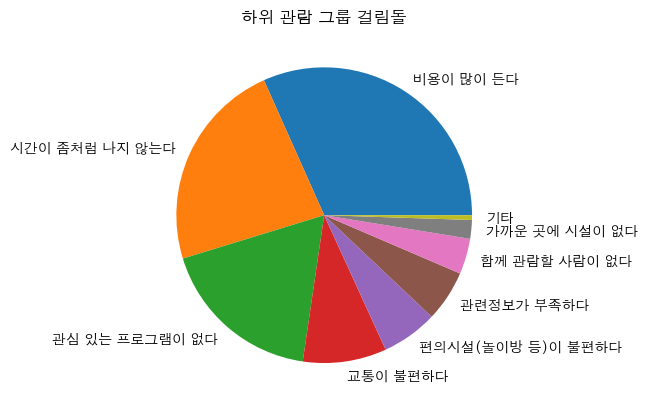

In [105]:
labels = ['비용이 많이 든다','시간이 좀처럼 나지 않는다','관심 있는 프로그램이 없다','교통이 불편하다','편의시설(놀이방 등)이 불편하다','관련정보가 부족하다','함께 관람할 사람이 없다','가까운 곳에 시설이 없다','기타']

plt.pie(low_data['block'].value_counts(),labels=labels)
plt.title('하위 관람 그룹 걸림돌')
plt.show()

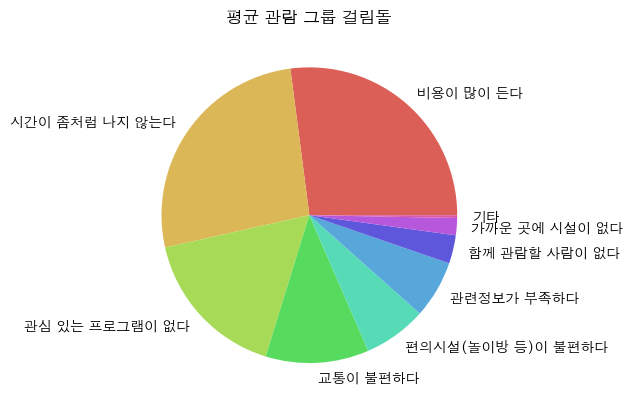

In [136]:
labels = ['비용이 많이 든다','시간이 좀처럼 나지 않는다','관심 있는 프로그램이 없다','교통이 불편하다','편의시설(놀이방 등)이 불편하다','관련정보가 부족하다','함께 관람할 사람이 없다','가까운 곳에 시설이 없다','기타']

plt.pie(average_data['block'].value_counts(),labels=labels)
plt.title('평균 관람 그룹 걸림돌')
plt.show()

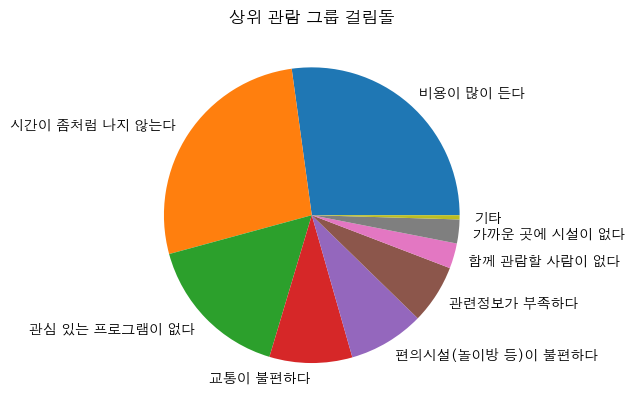

In [109]:
labels = ['비용이 많이 든다','시간이 좀처럼 나지 않는다','관심 있는 프로그램이 없다','교통이 불편하다','편의시설(놀이방 등)이 불편하다','관련정보가 부족하다','함께 관람할 사람이 없다','가까운 곳에 시설이 없다','기타']

plt.pie(high_data['block'].value_counts(),labels=labels)
plt.title('상위 관람 그룹 걸림돌')
plt.show()

Text(0.5, 1.0, '하위 관람 그룹 걸림돌')

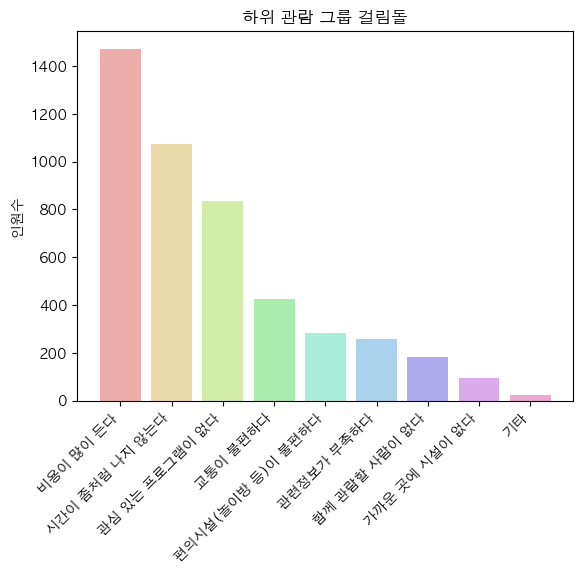

In [134]:
# 막대 그래프

y_pos = np.arange(len(labels))

colors = sns.color_palette('hls',len(low_data['block'].unique()))
plt.bar(y_pos, low_data['block'].value_counts(), align='center', alpha=0.5,color=colors)
plt.xticks(y_pos, labels, rotation=45,ha="right")
plt.ylabel('인원수')
plt.title('하위 관람 그룹 걸림돌')

Text(0.5, 1.0, '평균 관람 그룹 걸림돌')

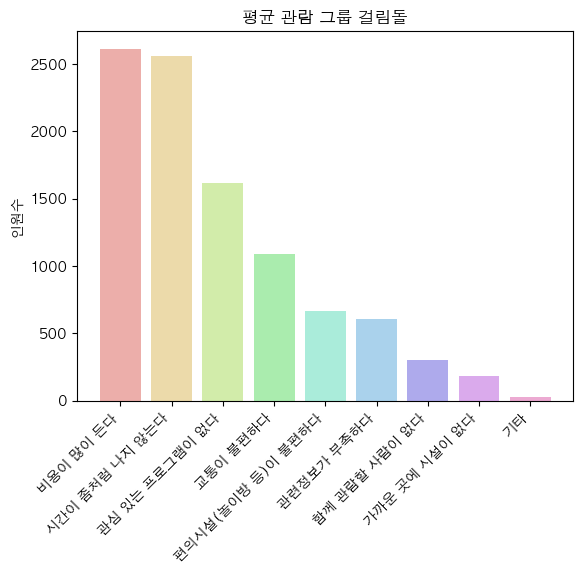

In [133]:
# 막대 그래프

y_pos = np.arange(len(labels))

colors = sns.color_palette('hls',len(average_data['block'].unique()))
plt.bar(y_pos, average_data['block'].value_counts(), align='center', alpha=0.5,color=colors)
plt.xticks(y_pos, labels, rotation=45,ha="right")
plt.ylabel('인원수')
plt.title('평균 관람 그룹 걸림돌')

Text(0.5, 1.0, '상위 관람 그룹 걸림돌')

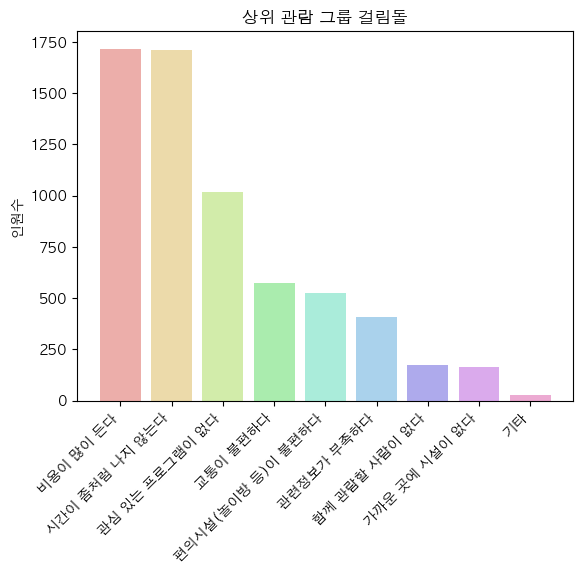

In [131]:
# 막대 그래프

y_pos = np.arange(len(labels))

colors = sns.color_palette('hls',len(high_data['block'].unique()))
plt.bar(y_pos, high_data['block'].value_counts(), align='center', alpha=0.5,color=colors)
plt.xticks(y_pos, labels, rotation=45,ha="right")
plt.ylabel('인원수')
plt.title('상위 관람 그룹 걸림돌')